# Mixture of Experts (MoE)

This notebook is intended to serve as a companion to the 'CONCERNING MIXTURE OF EXPERTS: AN OPTIMAL ARCHITECTURE' survey for the CAP6606 Machine Learning for ISR final project.

Mixture of Experts (MoE) was first introduced in 1991 by Jacobs, Jordan, Nowlan, and Hinton in their seminal paper, "Adaptive Mixtures of Local Experts" [1]. Originally, MoE was designed as a neural network where the feed-forward network (FFN) layer is replaced with multiple smaller FFNs, called "experts." The output is computed as a weighted sum of these experts, enabling efficient task specialization. The animation below illustrates this foundational concept.

In [5]:
%%manim -qm -v WARNING MoEForwardPass

Manim Community v0.19.0

Building on this idea, we dive into sparse MoE—a modern evolution that scales efficiently by activating only a subset of experts for each input. This innovation, pioneered by Shazeer et al. in Google’s 2017 paper, "Outrageously Large Neural Networks: The Sparsely-Gated Mixture-of-Experts Layer" [2], laid the foundation for much of MoE’s success today. The key contribution of this work is sparse-gating, or top-*k* routing, where only a select number of experts are activated for a given token during training and inference. This concept is visualized in the animation below.

In [ ]:
%%manim -qm -v WARNING SparseMoEAnimation

Manim Community v0.19.0

If you would like to follow along and run the code using Google Colab's free T4 GPU, please run the cells under the Required Setup heading. Also, if you are running out of memory during the running of the MoE demonstration, feel free to remove the animations as they do take up a decent amount of memory.

The Manim Animations Code heading contains the cells to generate the animations if needed.

## Required Setup

### Package Installations

#### Required Only for Manim Animation Generation - Not Recommended to run to save time and memory space - Will not effect the model running

In [45]:
!sudo apt update
!sudo apt install libcairo2-dev ffmpeg \
    texlive texlive-latex-extra texlive-fonts-extra \
    texlive-latex-recommended texlive-science \
    tipa libpango1.0-dev

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
36 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [36]:
!pip install manim

#### Must Have

In [2]:
!pip install torch
!pip install torchinfo
!pip install bitsandbytes
!pip install --upgrade transformers # Install latest version of transformers
!pip install --upgrade accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### ***Be sure to restart the session after installation and before running any code blocks below.***

## Manim Animations Code

In [37]:
from manim import *

### MoEForwardPass

In [4]:
# Black background
class MoEForwardPass(Scene):
    def construct(self):
        # Layout configuration
        COMPONENT_SPACING = 3.0
        EXPERT_VERTICAL_SPACING = 1.5
        SCALE_FACTOR = 0.9

        # Colors
        input_color = BLUE_C
        expert_colors = [GREEN_C, GREEN_D, GREEN_E]
        gate_color = PURPLE_B
        sum_color = ORANGE
        output_color = RED_C

        # Base positions
        input_pos = LEFT * 5
        gate_pos = input_pos + RIGHT * 2
        experts_pos = gate_pos + RIGHT * COMPONENT_SPACING
        sum_pos = experts_pos + RIGHT * COMPONENT_SPACING
        output_pos = sum_pos + RIGHT * COMPONENT_SPACING

        # Input Layer
        input_layer = Rectangle(
            width=1.0*SCALE_FACTOR,
            height=2.0*SCALE_FACTOR,
            color=input_color
        ).shift(input_pos)
        input_text = Text("Input", color=WHITE).scale(0.5*SCALE_FACTOR).move_to(input_layer.get_center())

        # Gating Network
        gate = Circle(
            radius=0.8*SCALE_FACTOR,
            color=gate_color
        ).shift(gate_pos)
        gate_text = Text("Gating\nNetwork", color=WHITE).scale(0.4*SCALE_FACTOR).move_to(gate.get_center())

        # Experts Layer
        experts = VGroup(*[
            Rectangle(
                width=1.5*SCALE_FACTOR,
                height=1.2*SCALE_FACTOR,
                color=color,
                fill_color=color,
                fill_opacity=0.0
            ).shift(
                experts_pos +
                UP*(i-1)*EXPERT_VERTICAL_SPACING
            )
            for i, color in enumerate(expert_colors)
        ])
        expert_texts = VGroup(*[
            Text(f"Expert {i+1}", color=WHITE)
            .scale(0.4*SCALE_FACTOR)
            .move_to(expert.get_center())
            for i, expert in enumerate(experts)
        ])

        # Weighted Sum
        weighted_sum = Circle(
            radius=0.8*SCALE_FACTOR,
            color=sum_color,
            fill_opacity=0.0
        ).shift(sum_pos)
        sum_text = Text("Weighted\nSum", color=WHITE).scale(0.4*SCALE_FACTOR).move_to(weighted_sum.get_center())

        # Output Layer
        output_layer = Rectangle(
            width=1.0*SCALE_FACTOR,
            height=2.0*SCALE_FACTOR,
            color=output_color
        ).shift(output_pos)
        output_text = Text("Output", color=WHITE).scale(0.4*SCALE_FACTOR).move_to(output_layer.get_center())

        # Connections
        input_to_gate = Line(
            input_layer.get_right(),
            gate.get_left(),
            color=GRAY,
            stroke_width=1.5
        )
        gate_to_experts = VGroup(*[
            Line(
                gate.get_right(),
                expert.get_left(),
                color=GRAY,
                stroke_width=1.5
            )
            for expert in experts
        ])
        experts_to_sum = VGroup(*[
            Line(
                expert.get_right(),
                weighted_sum.get_left(),
                color=GRAY,
                stroke_width=1.5
            )
            for expert in experts
        ])
        sum_to_output = Line(
            weighted_sum.get_right(),
            output_layer.get_left(),
            color=GRAY,
            stroke_width=2
        )

        # Animation sequence
        self.play(
            Create(input_layer),
            Write(input_text),
            Create(gate),
            Write(gate_text),
            Create(input_to_gate)
        )

        # Create experts
        for expert, text, connection in zip(experts, expert_texts, gate_to_experts):
            self.play(
                Create(expert),
                Write(text),
                Create(connection),
                run_time=0.5
            )

        # Create weighted sum and output
        self.play(
            Create(weighted_sum),
            Write(sum_text),
            *[Create(conn) for conn in experts_to_sum],
            Create(sum_to_output),
            Create(output_layer),
            Write(output_text)
        )

        # Forward pass animation
        data_dot = Dot(color=YELLOW, radius=0.15*SCALE_FACTOR).move_to(input_layer.get_right())

        self.play(Create(data_dot))
        self.play(data_dot.animate.move_to(gate.get_center()), run_time=0.5)

        # Split into two paths and remove original gate dot
        dot1 = data_dot.copy()
        dot3 = data_dot.copy()

        self.play(
            FadeOut(data_dot),  # Remove the original dot from gate
            dot1.animate.move_to(experts[0].get_center()),
            dot3.animate.move_to(experts[2].get_center()),
            run_time=1
        )

        # Highlight active experts with fill
        active_rectangles = VGroup(
            SurroundingRectangle(experts[0], color=YELLOW, buff=0.1, stroke_width=4),
            SurroundingRectangle(experts[2], color=YELLOW, buff=0.1, stroke_width=4)
        )

        self.play(
            Create(active_rectangles),
            experts[0].animate.set_fill(opacity=0.3),
            experts[2].animate.set_fill(opacity=0.3),
            dot1.animate.move_to(experts[0].get_right()),
            dot3.animate.move_to(experts[2].get_right()),
            run_time=1
        )

        # Move to weighted sum
        self.play(
            dot1.animate.move_to(weighted_sum.get_center()),
            dot3.animate.move_to(weighted_sum.get_center()),
            run_time=1.5
        )

        # Merge dots
        merged_dot = Dot(color=YELLOW, radius=0.2*SCALE_FACTOR).move_to(weighted_sum.get_center())
        self.play(
            FadeOut(dot1),
            FadeOut(dot3),
            GrowFromCenter(merged_dot)
        )

        # Move to output
        self.play(
            merged_dot.animate.move_to(output_layer.get_left()),
            run_time=1.5
        )
        self.play(FadeOut(merged_dot))

        # Clean up animations
        self.play(
            FadeOut(active_rectangles),
            experts[0].animate.set_fill(opacity=0.0),
            experts[2].animate.set_fill(opacity=0.0),
            run_time=0.5
        )

        self.wait(2)

### OLMoE Animation

In [49]:
class OlmoeArchitectureAnimation(Scene):
    def construct(self):
        # Title (scaled to fit)
        title = Text("OLMoE Architecture: Processing 'Hello'", font_size=32)
        self.play(Write(title))
        self.play(title.animate.to_edge(UP, buff=0.5))

        # Input token (centered vertically)
        token = Circle(radius=0.5, color=BLUE, fill_opacity=1).shift(LEFT * 6 + UP * 0)
        token_label = Text("Hello", font_size=28).next_to(token, DOWN)
        self.play(Create(token), Write(token_label))

        # Embedding layer (centered vertically)
        embedding = Rectangle(width=3, height=1.5, color=PURPLE, fill_opacity=0.5).shift(LEFT * 2 + UP * 0)
        embedding_label = Text("Embedding", font_size=28).move_to(embedding)
        arrow_token_emb = Arrow(token.get_right(), embedding.get_left(), color=WHITE)
        self.play(Create(embedding), Write(embedding_label), Create(arrow_token_emb))

        # Transformer layer (aligned down and right)
        transformer = Rectangle(width=4, height=5, color=TEAL, fill_opacity=0.5).shift(RIGHT * 3 + DOWN * 1)
        transformer_label = Text("Transformer Layer (1 of 16)", font_size=28).move_to(transformer.get_top() + UP * 1)

        # Self-Attention
        attention = Rectangle(width=2.5, height=1, color=BLUE_C, fill_opacity=0.5).move_to(transformer.get_center() + UP * 1.5)
        attention_label = Text("Self-Attention", font_size=24).move_to(attention)

        # MoE Block
        moe = Rectangle(width=3, height=2, color=YELLOW, fill_opacity=0.5).move_to(transformer.get_center() + DOWN * 1)
        moe_label = Text("MoE Block", font_size=24).move_to(moe)

        # Normalization
        norm1 = Rectangle(width=1.5, height=0.5, color=GRAY, fill_opacity=0.5).move_to(transformer.get_center() + UP * 3)
        norm1_label = Text("RMSNorm", font_size=20).move_to(norm1)
        norm2 = Rectangle(width=1.5, height=0.5, color=GRAY, fill_opacity=0.5).move_to(transformer.get_center())
        norm2_label = Text("RMSNorm", font_size=20).move_to(norm2)

        self.play(Create(transformer), Write(transformer_label),
                  Create(attention), Write(attention_label),
                  Create(moe), Write(moe_label),
                  Create(norm1), Write(norm1_label),
                  Create(norm2), Write(norm2_label))

        # Arrow to transformer
        arrow_emb_trans = Arrow(embedding.get_right(), transformer.get_left() + UP * 2, color=WHITE)
        self.play(Create(arrow_emb_trans))

        # Animate token through transformer
        token_copy = token.copy().set_color(TEAL)
        path_to_trans = VMobject()
        path_to_trans.set_points_as_corners([token.get_center(), embedding.get_center(), transformer.get_left() + UP * 2])
        self.play(MoveAlongPath(token_copy, path_to_trans), run_time=1.5)

        # Zoom into MoE block, fade out embedding, token, and arrow
        moe_group = VGroup(moe, moe_label)
        self.play(moe_group.animate.scale(2.5).move_to(ORIGIN).set_fill(opacity=0),  # Center and fade fill
                  FadeOut(VGroup(token, token_label, embedding, embedding_label, arrow_token_emb,
                                 arrow_emb_trans, token_copy, attention, attention_label,
                                 norm1, norm1_label, norm2, norm2_label, transformer, transformer_label)))

        # Gate and experts in MoE (experts shifted right, more spacing)
        gate = Rectangle(width=2, height=1, color=YELLOW, fill_opacity=0.7).move_to(moe.get_center() + LEFT * 2)
        gate_label = Text("Gate", font_size=24).move_to(gate)
        experts = VGroup(*[
            Circle(radius=0.4, color=GREEN, fill_opacity=1).shift(moe.get_center() + RIGHT * 1.5 + UP * (1.8 - i * 1.2))
            for i in range(4)
        ])
        expert_labels = VGroup(*[
            Text(f"Exp {i}", font_size=16).move_to(experts[i].get_left() + LEFT * 0.3 + UP * 0.3)
            for i in range(4)
        ])
        self.play(Create(gate), Write(gate_label), Create(experts), Write(expert_labels))

        # Arrows and weights for MoE (weights inside experts)
        arrow_token_gate = Arrow(moe.get_left(), gate.get_left(), color=WHITE)
        weights = [0.1, 0.8, 0.05, 0.9]  # Experts 1 and 3 are top-2
        weight_labels = VGroup(*[
            Text(f"w={weights[i]:.2f}", font_size=20, color=YELLOW, weight=NORMAL).move_to(experts[i].get_center())
            for i in range(4)
        ])
        # Background for top-2 weights
        weight_backgrounds = VGroup(*[
            Rectangle(width=0.8, height=0.4, color=BLACK, fill_opacity=0.5).move_to(experts[i].get_center())
            if i in [1, 3] else VMobject()  # Only for top-2
            for i in range(4)
        ])
        arrows_gate_experts = VGroup(*[
            Arrow(gate.get_right(), experts[i].get_left(), color=WHITE)
            for i in range(4)
        ])
        self.play(Create(arrow_token_gate), Create(arrows_gate_experts),
                  Create(weight_backgrounds), Write(weight_labels))

        # Highlight top-2 experts and their arrows
        top_experts = [1, 3]
        for i in top_experts:
            self.play(weight_labels[i].animate.scale(1.5).set_color(ORANGE).set_weight(BOLD),
                      weight_backgrounds[i].animate.set_fill(opacity=0.7),
                      experts[i].animate.set_fill(ORANGE, opacity=1),
                      arrows_gate_experts[i].animate.set_color(ORANGE).set_stroke(width=6),
                      run_time=0.5)

        # Token to top-2 experts
        token_copies = VGroup(*[token.copy().set_color(ORANGE).scale(0.5) for _ in top_experts])
        for i, idx in enumerate(top_experts):
            path = VMobject()
            path.set_points_as_corners([moe.get_left(), gate.get_center(), experts[idx].get_center()])
            self.play(MoveAlongPath(token_copies[i], path), run_time=1)

        # Scale and shift MoE block left, move output left
        moe_elements = VGroup(moe_group, gate, gate_label, experts, expert_labels,
                              arrow_token_gate, arrows_gate_experts, weight_labels,
                              weight_backgrounds, token_copies)
        self.play(moe_elements.animate.scale(0.4).shift(LEFT * 3))  # Scale down (1/2.5 = 0.4) and shift left

        # Output layer (moved left)
        output = Rectangle(width=2, height=1, color=RED, fill_opacity=0.5).shift(RIGHT * 2)
        output_label = Text("Output", font_size=24).move_to(output)
        output_token = Circle(radius=0.4, color=ORANGE, fill_opacity=1).shift(RIGHT * 4)
        output_token_label = Text("Output: Annyeonghaseyo", font_size=24).next_to(output_token, DOWN)

        # Arrows from top-2 experts to output
        arrows_experts_output = VGroup(*[
            Arrow(experts[i].get_right(), output.get_left(), color=WHITE)
            for i in top_experts
        ])
        arrow_output_token = Arrow(output.get_right(), output_token.get_left(), color=WHITE)

        self.play(Create(arrows_experts_output), Create(output), Write(output_label),
                  Create(arrow_output_token), Create(output_token), Write(output_token_label))

        # Animate both tokens to output
        final_tokens = VGroup(
            token_copies[0].copy().set_color(ORANGE),
            token_copies[1].copy().set_color(ORANGE)
        )
        path_final_1 = VMobject()
        path_final_1.set_points_as_corners([experts[top_experts[0]].get_center(), output.get_center(), output_token.get_center()])
        path_final_3 = VMobject()
        path_final_3.set_points_as_corners([experts[top_experts[1]].get_center(), output.get_center(), output_token.get_center()])
        self.play(
            MoveAlongPath(final_tokens[0], path_final_1),
            MoveAlongPath(final_tokens[1], path_final_3),
            run_time=1.5
        )

        # Fade out (ensure all arrows and tokens included)
        output_elements = VGroup(output, output_label, output_token, output_token_label,
                                 arrows_experts_output, arrow_output_token, final_tokens)
        self.play(FadeOut(moe_elements), FadeOut(output_elements))
        self.play(FadeOut(title))

        self.wait(1)

### White Background

In [ ]:
# White Background
class MoEForwardPassWhite(Scene):
    def construct(self):
        # Set white background
        self.camera.background_color = WHITE

        # Layout configuration
        COMPONENT_SPACING = 3.0
        EXPERT_VERTICAL_SPACING = 1.5
        SCALE_FACTOR = 0.9

        # High-contrast colors (dark variants)
        input_color = "#0A5C9E"  # Deep blue
        expert_colors = ["#2E7D32", "#1565C0", "#6A1B9A"]  # Dark green, blue, purple
        gate_color = "#D81B60"  # Magenta
        sum_color = "#FF8F00"  # Amber
        output_color = "#BF360C"  # Deep orange
        text_color = "#000000"  # Black
        active_color = "#FFD600"  # Bright yellow for highlights

        # Base positions
        input_pos = LEFT * 5
        gate_pos = input_pos + RIGHT * 2
        experts_pos = gate_pos + RIGHT * COMPONENT_SPACING
        sum_pos = experts_pos + RIGHT * COMPONENT_SPACING
        output_pos = sum_pos + RIGHT * COMPONENT_SPACING

        # Input Layer
        input_layer = Rectangle(
            width=1.0*SCALE_FACTOR,
            height=2.0*SCALE_FACTOR,
            color=input_color,
            fill_color=input_color,
            fill_opacity=0.7
        ).shift(input_pos)
        input_text = Text("Input", color=text_color).scale(0.5*SCALE_FACTOR).move_to(input_layer.get_center())

        # Gating Network
        gate = Circle(
            radius=0.8*SCALE_FACTOR,
            color=gate_color,
            fill_color=gate_color,
            fill_opacity=0.7
        ).shift(gate_pos)
        gate_text = Text("Gating\nNetwork", color=text_color).scale(0.4*SCALE_FACTOR).move_to(gate.get_center())

        # Experts Layer
        experts = VGroup(*[
            Rectangle(
                width=1.5*SCALE_FACTOR,
                height=1.2*SCALE_FACTOR,
                color=color,
                fill_color=color,
                fill_opacity=0.5
            ).shift(
                experts_pos +
                UP*(i-1)*EXPERT_VERTICAL_SPACING
            )
            for i, color in enumerate(expert_colors)
        ])
        expert_texts = VGroup(*[
            Text(f"Expert {i+1}", color=text_color)
            .scale(0.4*SCALE_FACTOR)
            .move_to(expert.get_center())
            for i, expert in enumerate(experts)
        ])

        # Weighted Sum
        weighted_sum = Circle(
            radius=0.8*SCALE_FACTOR,
            color=sum_color,
            fill_color=sum_color,
            fill_opacity=0.7
        ).shift(sum_pos)
        sum_text = Text("Weighted\nSum", color=text_color).scale(0.4*SCALE_FACTOR).move_to(weighted_sum.get_center())

        # Output Layer
        output_layer = Rectangle(
            width=1.0*SCALE_FACTOR,
            height=2.0*SCALE_FACTOR,
            color=output_color,
            fill_color=output_color,
            fill_opacity=0.7
        ).shift(output_pos)
        output_text = Text("Output", color=text_color).scale(0.4*SCALE_FACTOR).move_to(output_layer.get_center())

        # Connections
        input_to_gate = Line(
            input_layer.get_right(),
            gate.get_left(),
            color="#424242",  # Dark gray
            stroke_width=2.5
        )
        gate_to_experts = VGroup(*[
            Line(
                gate.get_right(),
                expert.get_left(),
                color="#424242",
                stroke_width=2.0
            )
            for expert in experts
        ])
        experts_to_sum = VGroup(*[
            Line(
                expert.get_right(),
                weighted_sum.get_left(),
                color="#424242",
                stroke_width=2.0
            )
            for expert in experts
        ])
        sum_to_output = Line(
            weighted_sum.get_right(),
            output_layer.get_left(),
            color="#424242",
            stroke_width=3.0
        )

        # Animation sequence
        self.play(
            Create(input_layer),
            Write(input_text),
            Create(gate),
            Write(gate_text),
            Create(input_to_gate)
        )

        # Create experts
        for expert, text, connection in zip(experts, expert_texts, gate_to_experts):
            self.play(
                Create(expert),
                Write(text),
                Create(connection),
                run_time=0.5
            )

        # Create weighted sum and output
        self.play(
            Create(weighted_sum),
            Write(sum_text),
            *[Create(conn) for conn in experts_to_sum],
            Create(sum_to_output),
            Create(output_layer),
            Write(output_text)
        )

        # Forward pass animation
        data_dot = Dot(color=active_color, radius=0.15*SCALE_FACTOR).move_to(input_layer.get_right())

        self.play(Create(data_dot))
        self.play(data_dot.animate.move_to(gate.get_center()), run_time=0.5)

        # Split into two paths
        dot1 = data_dot.copy()
        dot3 = data_dot.copy()

        self.play(
            FadeOut(data_dot),
            dot1.animate.move_to(experts[0].get_center()),
            dot3.animate.move_to(experts[2].get_center()),
            run_time=1
        )

        # Highlight active experts
        active_rectangles = VGroup(
            SurroundingRectangle(experts[0], color=active_color, buff=0.1, stroke_width=5),
            SurroundingRectangle(experts[2], color=active_color, buff=0.1, stroke_width=5)
        )

        self.play(
            Create(active_rectangles),
            experts[0].animate.set_fill(opacity=0.9),
            experts[2].animate.set_fill(opacity=0.9),
            dot1.animate.move_to(experts[0].get_right()),
            dot3.animate.move_to(experts[2].get_right()),
            run_time=1
        )

        # Move to weighted sum
        self.play(
            dot1.animate.move_to(weighted_sum.get_center()),
            dot3.animate.move_to(weighted_sum.get_center()),
            run_time=1.5
        )

        # Merge dots
        merged_dot = Dot(color=active_color, radius=0.2*SCALE_FACTOR).move_to(weighted_sum.get_center())
        self.play(
            FadeOut(dot1),
            FadeOut(dot3),
            GrowFromCenter(merged_dot)
        )

        # Move to output
        self.play(
            merged_dot.animate.move_to(output_layer.get_left()),
            run_time=1.5
        )
        self.play(FadeOut(merged_dot))

        # Clean up
        self.play(
            FadeOut(active_rectangles),
            experts[0].animate.set_fill(opacity=0.5),
            experts[2].animate.set_fill(opacity=0.5),
            run_time=0.5
        )

        self.wait(2)

### Med-MoE

In [ ]:
class MedMoEPhase3(Scene):
    def construct(self):
        # Define positions for each component
        input_block = Rectangle(width=1.5, height=1, color=WHITE, fill_opacity=0.3).shift(LEFT * 5 + UP * 1)
        input_label = Tex("Input").scale(0.5).move_to(input_block)
        self_attention = Rectangle(width=2, height=1, color=BLUE, fill_opacity=0.3).shift(LEFT * 3 + UP * 1)
        self_attention_label = Tex("Self-Attention").scale(0.5).move_to(self_attention)
        add_norm_1 = Rectangle(width=2, height=1, color=GREEN, fill_opacity=0.3).shift(LEFT * 1 + UP * 1)
        add_norm_1_label = Tex("Add \& Norm").scale(0.5).move_to(add_norm_1)
        router = Rectangle(width=2, height=1, color=GREEN, fill_opacity=0.3).shift(RIGHT * 1 + UP * 1)
        router_label = Tex("Router").scale(0.5).move_to(router)

        # Domain Experts (Meta-Expert, X-Ray, MRI, CT)
        meta_expert = Rectangle(width=2, height=1, color=ORANGE, fill_opacity=0.3).shift(LEFT * 3 + DOWN * 1)
        meta_expert_label = Tex("Meta-Expert").scale(0.5).move_to(meta_expert)
        xray = Rectangle(width=1.5, height=1, color=RED, fill_opacity=0.3).shift(LEFT * 0.5 + DOWN * 1)
        xray_label = Tex("X-Ray").scale(0.4).move_to(xray)
        mri = Rectangle(width=1.5, height=1, color=RED, fill_opacity=0.1).shift(RIGHT * 1 + DOWN * 1)
        mri_label = Tex("MRI").scale(0.4).move_to(mri)
        ct = Rectangle(width=1.5, height=1, color=RED, fill_opacity=0.1).shift(RIGHT * 2.5 + DOWN * 1)
        ct_label = Tex("CT").scale(0.4).move_to(ct)

        add_norm_2 = Rectangle(width=2, height=1, color=GREEN, fill_opacity=0.3).shift(RIGHT * 1 + DOWN * 3)
        add_norm_2_label = Tex("Add \& Norm").scale(0.5).move_to(add_norm_2)
        output_block = Rectangle(width=1.5, height=1, color=WHITE, fill_opacity=0.3).shift(RIGHT * 3 + DOWN * 3)
        output_label = Tex("Output").scale(0.5).move_to(output_block)

        # Arrows between main components
        arrow1 = Arrow(input_block.get_right(), self_attention.get_left(), buff=0.1)
        arrow2 = Arrow(self_attention.get_right(), add_norm_1.get_left(), buff=0.1)
        arrow3 = Arrow(add_norm_1.get_right(), router.get_left(), buff=0.1)
        arrow4 = Arrow(router.get_bottom(), xray.get_top(), buff=0.1)
        arrow5 = Arrow(router.get_bottom(), mri.get_top(), buff=0.1)
        arrow6 = Arrow(router.get_bottom(), ct.get_top(), buff=0.1)
        arrow7 = Arrow(xray.get_bottom(), add_norm_2.get_top(), buff=0.1)
        arrow8 = Arrow(mri.get_bottom(), add_norm_2.get_top(), buff=0.1)
        arrow9 = Arrow(ct.get_bottom(), add_norm_2.get_top(), buff=0.1)
        arrow10 = Arrow(add_norm_2.get_right(), output_block.get_left(), buff=0.1)

        # Connections for Meta-Expert
        arrow_meta1 = Arrow(router.get_bottom(), meta_expert.get_top(), buff=0.1)  # Router to Meta-Expert
        arrow_meta2 = Arrow(meta_expert.get_bottom(), add_norm_2.get_top(), buff=0.1)  # Meta-Expert to Add & Norm

        # Group components for animation
        input_group = VGroup(input_block, input_label)
        self_attention_group = VGroup(self_attention, self_attention_label)
        add_norm_1_group = VGroup(add_norm_1, add_norm_1_label)
        router_group = VGroup(router, router_label)
        xray_group = VGroup(xray, xray_label)
        mri_group = VGroup(mri, mri_label)
        ct_group = VGroup(ct, ct_label)
        meta_expert_group = VGroup(meta_expert, meta_expert_label)
        add_norm_2_group = VGroup(add_norm_2, add_norm_2_label)
        output_group = VGroup(output_block, output_label)

        # Animation: Fade in components sequentially
        self.play(FadeIn(input_group))
        self.play(FadeIn(self_attention_group), Create(arrow1))
        self.play(FadeIn(add_norm_1_group), Create(arrow2))
        self.play(FadeIn(router_group), Create(arrow3))
        self.play(FadeIn(meta_expert_group, xray_group, mri_group, ct_group),
                  Create(arrow_meta1), Create(arrow4), Create(arrow5), Create(arrow6))
        self.play(FadeIn(add_norm_2_group), Create(arrow_meta2), Create(arrow7), Create(arrow8), Create(arrow9))
        self.play(FadeIn(output_group), Create(arrow10))

        # Animation: Highlight the flow of data
        dot = Dot(input_block.get_right(), color=YELLOW)
        self.play(MoveAlongPath(dot, arrow1), run_time=0.5)
        self.play(MoveAlongPath(dot, arrow2), run_time=0.5)
        self.play(MoveAlongPath(dot, arrow3), run_time=0.5)

        # Animation: Router activates experts (highlight X-Ray and Meta-Expert)
        self.play(
            xray_group.animate.set_fill(YELLOW, opacity=0.5),
            meta_expert_group.animate.set_fill(YELLOW, opacity=0.5)
        )
        self.play(MoveAlongPath(dot, arrow4), MoveAlongPath(dot.copy(), arrow_meta1), run_time=0.5)
        self.play(MoveAlongPath(dot, arrow7), MoveAlongPath(dot.copy(), arrow_meta2), run_time=0.5)
        self.play(MoveAlongPath(dot, arrow10), run_time=0.5)

        # Animation: Highlight final output
        self.play(output_group.animate.scale(1.5).set_fill(YELLOW, opacity=0.5), run_time=0.5)
        self.play(output_group.animate.scale(1/1.5).set_fill(WHITE, opacity=0.3), run_time=0.5)

        self.wait(2)

### SparseMoE - Google

In [ ]:
class SparseMoEAnimation(Scene):
    def construct(self):
        # Title
        title = Text("Sparse Mixture of Experts (SparseMoE)", font_size=36)
        self.play(Write(title))
        self.play(title.animate.to_edge(UP))

        # Create input node
        input_node = Circle(radius=0.5, color=BLUE, fill_opacity=0.5).shift(LEFT * 5)
        input_label = Text("Input", font_size=24).next_to(input_node, DOWN)
        self.play(Create(input_node), Write(input_label))

        # Create gating network
        gate = Rectangle(height=1, width=2, color=YELLOW, fill_opacity=0.3).shift(LEFT * 2)
        gate_label = Text("Gating\nNetwork", font_size=20).move_to(gate)
        self.play(Create(gate), Write(gate_label))

        # Create experts (4 experts, now wider)
        experts = VGroup()
        expert_labels = VGroup()
        for i in range(4):
            expert = Rectangle(height=1, width=1.5, color=GREEN, fill_opacity=0.3).shift(RIGHT * 2 + UP * (1.5 - i))
            label = Text(f"Expert {i+1}", font_size=18).move_to(expert)
            experts.add(expert)
            expert_labels.add(label)
        self.play(Create(experts), Write(expert_labels))

        # Create output node
        output_node = Circle(radius=0.5, color=RED, fill_opacity=0.5).shift(RIGHT * 5)
        output_label = Text("Output", font_size=24).next_to(output_node, DOWN)
        self.play(Create(output_node), Write(output_label))

        # Animate data flow: Input to Gating
        arrow1 = Arrow(input_node.get_right(), gate.get_left(), color=WHITE)
        self.play(Create(arrow1))

        # Gating weights visualization (bar chart for expert weights)
        weights = [0.4, 0.3, 0.2, 0.1]  # Example weights
        bars = VGroup()
        bar_labels = VGroup()
        for i, w in enumerate(weights):
            bar = Rectangle(height=w * 3, width=0.4, fill_color=BLUE, fill_opacity=0.5)
            bar.shift(LEFT * 2 + DOWN * 2 + RIGHT * (i * 0.5 - 0.75))
            bars.add(bar)
            label = Text(f"{w:.1f}", font_size=16).next_to(bar, UP, buff=0.1)
            bar_labels.add(label)
        self.play(Create(bars), Write(bar_labels))
        top_k_label = Text("Select Top-2 Experts", font_size=20).shift(DOWN * 3.5)
        self.play(Write(top_k_label))

        # Highlight top-2 experts (indices 0 and 1)
        top_k = [0, 1]
        for i in range(4):
            if i not in top_k:
                self.play(experts[i].animate.set_fill(opacity=0.1), expert_labels[i].animate.set_fill(opacity=0.3))

        # Animate connections from gate to top-2 experts
        arrows_to_experts = VGroup()
        for i in top_k:
            arrow = Arrow(gate.get_right(), experts[i].get_left(), color=WHITE)
            arrows_to_experts.add(arrow)
        self.play(Create(arrows_to_experts))

        # Animate expert processing
        for i in top_k:
            self.play(experts[i].animate.set_fill(color=ORANGE, opacity=0.5), run_time=0.5)

        # Animate outputs from experts to output node
        arrows_from_experts = VGroup()
        for i in top_k:
            arrow = Arrow(experts[i].get_right(), output_node.get_left(), color=WHITE)
            arrows_from_experts.add(arrow)
        self.play(Create(arrows_from_experts))

        # Show weighted combination (text moved down)
        output_text = Text("Weighted\nSum", font_size=20).next_to(output_node, LEFT, buff=0.5).shift(DOWN * 0.5, RIGHT * 0.25)
        self.play(Write(output_text))
        self.play(output_node.animate.set_fill(color=PURPLE, opacity=0.7))

        # Fade out weights and labels
        self.play(FadeOut(bars), FadeOut(bar_labels), FadeOut(top_k_label))

        # Final animation: highlight the entire flow
        self.play(
            input_node.animate.set_fill(color=BLUE, opacity=0.8),
            gate.animate.set_fill(color=YELLOW, opacity=0.5),
            *[experts[i].animate.set_fill(color=ORANGE, opacity=0.6) for i in top_k],
            output_node.animate.set_fill(color=PURPLE, opacity=0.8),
            run_time=1.5
        )

        # Hold the final scene
        self.wait(2)

### SparseMoE - White

In [ ]:
class SparseMoEWhite(Scene):
    def construct(self):
        self.camera.background_color = WHITE

        # Title
        title = Text("Sparse Mixture of Experts (SparseMoE)", font_size=36, color=BLACK)
        self.play(Write(title))
        self.play(title.animate.to_edge(UP))

        # Create input node
        input_node = Circle(radius=0.5, color=BLUE_D, fill_opacity=0.7).shift(LEFT * 5)
        input_label = Text("Input", font_size=24, color=BLACK).next_to(input_node, DOWN)
        self.play(Create(input_node), Write(input_label))

        # Create gating network
        gate = Rectangle(height=1, width=2, color=GOLD_D, fill_opacity=0.5).shift(LEFT * 2)
        gate_label = Text("Gating\nNetwork", font_size=20, color=BLACK).move_to(gate)
        self.play(Create(gate), Write(gate_label))

        # Create experts (4 experts)
        experts = VGroup()
        expert_labels = VGroup()
        for i in range(4):
            expert = Rectangle(height=1, width=1.5, color=GREEN_D, fill_opacity=0.5).shift(RIGHT * 2 + UP * (1.5 - i))
            label = Text(f"Expert {i+1}", font_size=18, color=BLACK).move_to(expert)
            experts.add(expert)
            expert_labels.add(label)
        self.play(Create(experts), Write(expert_labels))

        # Create output node
        output_node = Circle(radius=0.5, color=MAROON_D, fill_opacity=0.7).shift(RIGHT * 5)
        output_label = Text("Output", font_size=24, color=BLACK).next_to(output_node, DOWN)
        self.play(Create(output_node), Write(output_label))

        # Animate data flow: Input to Gating
        arrow1 = Arrow(input_node.get_right(), gate.get_left(), color=BLACK)
        self.play(Create(arrow1))

        # Gating weights visualization
        weights = [0.4, 0.3, 0.2, 0.1]
        bars = VGroup()
        bar_labels = VGroup()
        for i, w in enumerate(weights):
            bar = Rectangle(height=w * 3, width=0.4, fill_color=BLUE_D, fill_opacity=0.7, stroke_color=BLACK)
            bar.shift(LEFT * 2 + DOWN * 2 + RIGHT * (i * 0.5 - 0.75))
            bars.add(bar)
            label = Text(f"{w:.1f}", font_size=16, color=BLACK).next_to(bar, UP, buff=0.1)
            bar_labels.add(label)
        self.play(Create(bars), Write(bar_labels))
        top_k_label = Text("Select Top-2 Experts", font_size=20, color=BLACK).shift(DOWN * 3.5)
        self.play(Write(top_k_label))

        # Highlight top-2 experts
        top_k = [0, 1]
        for i in range(4):
            if i not in top_k:
                self.play(experts[i].animate.set_fill(opacity=0.1), expert_labels[i].animate.set_opacity(0.3))

        # Connections to top-2 experts
        arrows_to_experts = VGroup()
        for i in top_k:
            arrow = Arrow(gate.get_right(), experts[i].get_left(), color=BLACK)
            arrows_to_experts.add(arrow)
        self.play(Create(arrows_to_experts))

        # Expert processing
        for i in top_k:
            self.play(experts[i].animate.set_fill(color=ORANGE, opacity=0.7), run_time=0.5)

        # Outputs to final node
        arrows_from_experts = VGroup()
        for i in top_k:
            arrow = Arrow(experts[i].get_right(), output_node.get_left(), color=BLACK)
            arrows_from_experts.add(arrow)
        self.play(Create(arrows_from_experts))

        # Weighted combination
        output_text = Text("Weighted\nSum", font_size=20, color=BLACK).next_to(output_node, LEFT, buff=0.5).shift(DOWN * 0.5, RIGHT * 0.25)
        self.play(Write(output_text))
        self.play(output_node.animate.set_fill(color=PURPLE_D, opacity=0.9))

        # Cleanup
        self.play(FadeOut(bars), FadeOut(bar_labels), FadeOut(top_k_label))

        # Final highlight
        self.play(
            input_node.animate.set_fill(opacity=0.9),
            gate.animate.set_fill(opacity=0.7),
            *[experts[i].animate.set_fill(opacity=0.8) for i in top_k],
            output_node.animate.set_fill(opacity=1),
            run_time=1.5
        )

        self.wait(2)

## Code Example

In this section, we will implement the Med-MoE model based on the Med-MoE paper [3]. The objective is to gain a deep understanding of a state-of-the-art Mixture of Experts (MoE) model by constructing its code and examining the resulting model dictionary. While this implementation may not precisely replicate the original, it is designed to provide an educational insight into the construction of this advanced model architecture.

### Library Imports

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import math

### Med-MoE Model Design

Before implementing the code, let's overview the Med-MoE model design from the Med-MoE paper [3]. The model builds on a standard Transformer with Self-Attention, incorporating Layer Normalization before the router. The router directs inputs to two expert groups: Domain Experts and a single Meta Expert. The Meta Expert holds global knowledge shared across all Domain Experts and is always activated by the router, while only one Domain Expert, specialized for medical modalities like X-Rays, MRIs, or CTs, is activated alongside it. The outputs from the Meta Expert and the selected Domain Expert are combined and normalized to produce the final output, as depicted in the animation below.

In [ ]:
%%manim -qm -v WARNING MedMoEPhase3

Manim Community v0.19.0

Now let's dive into the pytorch code implementation of this MoE model.

First we will start with the Multi-Head Self-Attention module based on "Attention is All You Need" [4].

In [16]:
# Multi-Head Self-Attention module based on "Attention is All You Need" [4].
# This component allows the model to focus on different parts of the input sequence simultaneously.
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        # Initialize the attention module.
        # d_model: dimensionality of input/output (e.g., 512).
        # num_heads: number of attention heads (e.g., 8).
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model % num_heads == 0  # Ensure d_model is divisible by num_heads.
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension of each head.

        # Linear layers for projecting input to queries (Q), keys (K), values (V), and output (O).
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        # Forward pass for multi-head self-attention.
        # Input x: (batch_size, seq_len, d_model).
        batch_size = x.size(0)

        # Project input to Q, K, V and reshape for multi-head attention.
        # Shape after view: (batch_size, seq_len, num_heads, d_k).
        # Transpose to: (batch_size, num_heads, seq_len, d_k) for parallel head computation.
        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Compute scaled dot-product attention: softmax(QK^T / sqrt(d_k))V.
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)  # Shape: (batch_size, num_heads, seq_len, seq_len).
        attn = F.softmax(scores, dim=-1)  # Attention weights.
        context = torch.matmul(attn, V)  # Shape: (batch_size, num_heads, seq_len, d_k).

        # Reshape and project back to d_model.
        # Transpose to: (batch_size, seq_len, num_heads, d_k), then reshape to: (batch_size, seq_len, d_model).
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(context)  # Final linear transformation.
        return output  # Output: (batch_size, seq_len, d_model).

Next, we can define the Feed-Forward Network that will be used within our Domain and Meta Experts. This helps prevent errors by reducing repetitive code.

In [17]:
# Feed-Forward Neural Network used within Domain and Meta Experts.
# Applies two linear transformations with ReLU activation for non-linearity.
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        # Initialize the FFN.
        # d_model: input/output dimensionality.
        # d_ff: hidden layer dimensionality (e.g., 2048).
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)  # First linear layer.
        self.fc2 = nn.Linear(d_ff, d_model)  # Second linear layer.

    def forward(self, x):
        # Forward pass: Linear -> ReLU -> Linear.
        x = F.relu(self.fc1(x))  # Apply ReLU activation after first layer.
        x = self.fc2(x)  # Project back to d_model.
        return x  # Output: (batch_size, seq_len, d_model).

The Router is a critical component of the Med-MoE model’s Mixture of Experts (MoE) architecture. It employs a linear layer to compute logits for each token based on its input features. These logits are then processed using Gumbel-Softmax to produce probabilities, selecting a single Domain Expert per token. This sparse activation mechanism ensures efficient inference by routing each token to one of the three Domain Experts, optimizing resource utilization while leveraging specialized knowledge for medical modalities like X-Rays, MRIs, and CTs.

In [18]:
# Router module to select a single Domain Expert per input token.
# Uses Gumbel-Softmax for differentiable expert selection.
class Router(nn.Module):
    def __init__(self, d_model, num_domain_experts):
        # Initialize the router.
        # d_model: input dimensionality.
        # num_domain_experts: number of Domain Experts (e.g., 3).
        super(Router, self).__init__()
        self.fc = nn.Linear(d_model, num_domain_experts)  # Linear layer to compute logits.

    def forward(self, x):
        # Forward pass to select one Domain Expert.
        # Input x: (batch_size, seq_len, d_model).
        logits = self.fc(x)  # Compute logits for each expert: (batch_size, seq_len, num_domain_experts).
        # Apply Gumbel-Softmax to select one expert differentiably (hard=True ensures one-hot output).
        probs = F.gumbel_softmax(logits, tau=1.0, hard=True, dim=-1)
        return probs  # Output: (batch_size, seq_len, num_domain_experts) with one-hot probabilities.

Next, we define the Domain Expert, a key component of the Med-MoE model’s Mixture of Experts (MoE) architecture. Each Domain Expert is designed to capture specialized knowledge for a specific medical modality, such as X-Rays, MRIs, or CTs. Implemented as a feed-forward neural network followed by layer normalization, these experts process input tokens selected by the Router, enabling the model to efficiently leverage modality-specific expertise while maintaining sparsity during inference.

In [19]:
# Domain Expert module tailored to a specific medical modality (e.g., X-Rays, MRIs, CTs).
# Processes input with a feed-forward network and normalization.
class DomainExpert(nn.Module):
    def __init__(self, d_model, d_ff):
        # Initialize the Domain Expert.
        # d_model: input/output dimensionality.
        # d_ff: hidden layer dimensionality.
        super(DomainExpert, self).__init__()
        self.ffn = FeedForward(d_model, d_ff)  # Feed-forward network.
        self.norm = nn.LayerNorm(d_model)  # Layer normalization for stability.

    def forward(self, x):
        # Forward pass for the Domain Expert.
        x = self.ffn(x)  # Process input through FFN.
        x = self.norm(x)  # Apply layer normalization.
        return x  # Output: (batch_size, seq_len, d_model).

Next, we define the Meta Expert, a vital component of the Med-MoE model’s Mixture of Experts (MoE) architecture. Unlike Domain Experts, the Meta Expert is always activated during inference, capturing global knowledge shared across all medical modalities, such as X-Rays, MRIs, and CTs. Implemented as a feed-forward neural network followed by layer normalization, it complements the modality-specific Domain Experts, enhancing the model’s ability to integrate universal features efficiently.

In [20]:
# Meta Expert module to capture global knowledge shared across all modalities.
# Always activated, processes input with a feed-forward network and normalization.
class MetaExpert(nn.Module):
    def __init__(self, d_model, d_ff):
        # Initialize the Meta Expert.
        # d_model: input/output dimensionality.
        # d_ff: hidden layer dimensionality.
        super(MetaExpert, self).__init__()
        self.ffn = FeedForward(d_model, d_ff)  # Feed-forward network.
        self.norm = nn.LayerNorm(d_model)  # Layer normalization.

    def forward(self, x):
        # Forward pass for the Meta Expert.
        x = self.ffn(x)  # Process input through FFN.
        x = self.norm(x)  # Apply layer normalization.
        return x  # Output: (batch_size, seq_len, d_model).

Finally, we define the Med-MoE model, which integrates the Transformer backbone, Router, Domain Experts, and Meta Expert into a cohesive Mixture of Experts (MoE) architecture. The Transformer backbone processes input tokens with multi-head self-attention, followed by the Router, which selects a single Domain Expert per token for modality-specific processing (e.g., X-Rays, MRIs, CTs). The Meta Expert, always active, captures global knowledge. As detailed in the code and explanatory comments, the model combines the outputs of the selected Domain Expert and the Meta Expert, followed by normalization, to produce the final output, achieving efficient inference through sparse activation.

In [21]:
# Med-MoE model combining Transformer backbone, router, and experts.
# Implements the architecture described in the Med-MoE paper [3].
class MedMoE(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_domain_experts=3, d_ff=2048):
        # Initialize the Med-MoE model.
        # d_model: model dimensionality (default: 512).
        # num_heads: number of attention heads (default: 8).
        # num_domain_experts: number of Domain Experts (default: 3).
        # d_ff: hidden layer dimensionality (default: 2048).
        super(MedMoE, self).__init__()
        self.d_model = d_model

        # Transformer components: self-attention with pre-normalization.
        self.norm1 = nn.LayerNorm(d_model)  # Layer normalization before attention.
        self.attention = MultiHeadSelfAttention(d_model, num_heads)  # Multi-head self-attention.
        self.norm2 = nn.LayerNorm(d_model)  # Layer normalization after attention.

        # Router to select one Domain Expert per input token.
        self.router = Router(d_model, num_domain_experts)

        # Domain Experts for specific medical modalities (e.g., X-Rays, MRIs, CTs).
        self.domain_experts = nn.ModuleList([
            DomainExpert(d_model, d_ff) for _ in range(num_domain_experts)
        ])

        # Meta Expert to capture global knowledge, always activated.
        self.meta_expert = MetaExpert(d_model, d_ff)

        # Output normalization to stabilize the combined expert outputs.
        self.output_norm = nn.LayerNorm(d_model)

        # Simple input embedding (placeholder for token embeddings).
        self.embedding = nn.Linear(d_model, d_model)

    def forward(self, x):
        # Forward pass for the Med-MoE model.
        # Input x: (batch_size, seq_len, d_model).
        x = self.embedding(x)  # Project input to embedding space.

        # Self-Attention block with pre-normalization and residual connection.
        residual = x  # Store input for residual connection.
        x = self.norm1(x)  # Apply normalization before attention.
        x = self.attention(x)  # Compute multi-head self-attention.
        x = residual + x  # Add residual connection.
        x = self.norm2(x)  # Apply normalization after attention.

        # Router selects one Domain Expert per token.
        router_probs = self.router(x)  # Shape: (batch_size, seq_len, num_domain_experts).

        # Meta Expert is always activated to capture global knowledge.
        meta_output = self.meta_expert(x)  # Shape: (batch_size, seq_len, d_model).

        # Compute Domain Expert outputs, weighted by router probabilities.
        domain_outputs = torch.zeros_like(x)  # Initialize output tensor.
        for i, expert in enumerate(self.domain_experts):
            expert_output = expert(x)  # Process input through the expert.
            # Weight the expert’s output by the router’s probability for this expert.
            domain_outputs += router_probs[:, :, i:i+1] * expert_output

        # Combine Meta and Domain Expert outputs by summation.
        output = meta_output + domain_outputs

        # Apply final normalization to stabilize the output.
        output = self.output_norm(output)

        return output  # Output: (batch_size, seq_len, d_model).

    def count_parameters(self, active=False):
        # Count total or active parameters.
        # active=True: count parameters used per token (Meta Expert + one Domain Expert + shared).
        total_params = 0
        active_params = 0

        # Embedding (shared, always active).
        emb_params = sum(p.numel() for p in self.embedding.parameters())
        total_params += emb_params
        active_params += emb_params

        # Shared components: attention, norms, router.
        shared_params = (
            sum(p.numel() for p in self.norm1.parameters()) +
            sum(p.numel() for p in self.norm2.parameters()) +
            sum(p.numel() for p in self.attention.parameters()) +
            sum(p.numel() for p in self.router.parameters()) +
            sum(p.numel() for p in self.output_norm.parameters())
        )
        total_params += shared_params
        active_params += shared_params

        # Meta Expert (always active).
        meta_params = sum(p.numel() for p in self.meta_expert.parameters())
        total_params += meta_params
        active_params += meta_params

        # Domain Experts (only one active per token).
        for expert in self.domain_experts:
            expert_params = sum(p.numel() for p in expert.parameters())
            total_params += expert_params
            if active:
                active_params += expert_params / len(self.domain_experts)  # Average over experts.

        return total_params, active_params if active else total_params

In [30]:
# Initialize scaled model.
model = MedMoE(
    d_model=512,
    num_heads=8,
    num_domain_experts=4,
    d_ff=2048
)
# Count parameters.
total_params, active_params = model.count_parameters(active=True)
print(f"Total Parameters: {total_params:,}")
print(f"Active Parameters (per token): {active_params:,}")
print(f"Percent Active (per token): {active_params/total_params * 100:.2f}%")

# Simulate inference with sample input.
batch_size, seq_len, d_model = 32, 128, 512
x = torch.randn(batch_size, seq_len, d_model)
output = model(x)

# Demonstrate active experts during inference.
print("\nSimulating inference to show active experts:")
x = x.to(model.norm1.weight.device)  # Ensure device consistency.
x = model.norm1(x)
x = model.attention(x)
x = model.norm2(x)
router_probs = model.router(x)  # Shape: (batch_size, seq_len, num_domain_experts).
selected_expert = torch.argmax(router_probs, dim=-1)  # Expert index per token.
print(f"Selected Domain Expert indices (first batch, first 5 tokens): {selected_expert[0, :5].tolist()}")

# Complete forward pass for output shape.
output = model(x)
print(f"\nOutput shape: {output.shape}")

Total Parameters: 11,822,084
Active Parameters (per token): 5,519,876.0
Percent Active (per token): 46.69%

Simulating inference to show active experts:
Selected Domain Expert indices (first batch, first 5 tokens): [1, 3, 1, 2, 3]

Output shape: torch.Size([32, 128, 512])


The Med-MoE model exemplifies the efficiency of the Mixture of Experts (MoE) architecture. With approximately 12 million total parameters, only about 5.5 million - roughly 46.69% - are activated per token at inference. This sparsity, where only one Domain Expert and the Meta Expert are used alongside shared components, allows the model to efficiently scale capacity for diverse tasks or medical modalities, such as X-Rays, MRIs, and CTs, while significantly reducing computational demands and enhancing inference speed.

During inference, we displayed the active Domain Experts for the first five tokens in the first batch. The numbers shown are the indices of the activated Domain Experts. For instance, if the first token activates Expert 3 (index 2) out of the four available Domain Experts, it illustrates the MoE’s sparse activation, where only one expert per token is selected by the router, enhancing efficiency while leveraging specialized knowledge for medical modalities.

Now let's check the model dictionary to see how the model is structured after we implemented it.

In [31]:
print(model)

MedMoE(
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (attention): MultiHeadSelfAttention(
    (W_q): Linear(in_features=512, out_features=512, bias=True)
    (W_k): Linear(in_features=512, out_features=512, bias=True)
    (W_v): Linear(in_features=512, out_features=512, bias=True)
    (W_o): Linear(in_features=512, out_features=512, bias=True)
  )
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (router): Router(
    (fc): Linear(in_features=512, out_features=4, bias=True)
  )
  (domain_experts): ModuleList(
    (0-3): 4 x DomainExpert(
      (ffn): FeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (meta_expert): MetaExpert(
    (ffn): FeedForward(
      (fc1): Linear(in_features=512, out_features=2048, bias=True)
      (fc2): Linear(in_features=2048, out_featu

We can also see the per layer breakdown of where our parameters are located.

In [32]:
summary(model)

Layer (type:depth-idx)                   Param #
MedMoE                                   --
├─LayerNorm: 1-1                         1,024
├─MultiHeadSelfAttention: 1-2            --
│    └─Linear: 2-1                       262,656
│    └─Linear: 2-2                       262,656
│    └─Linear: 2-3                       262,656
│    └─Linear: 2-4                       262,656
├─LayerNorm: 1-3                         1,024
├─Router: 1-4                            --
│    └─Linear: 2-5                       2,052
├─ModuleList: 1-5                        --
│    └─DomainExpert: 2-6                 --
│    │    └─FeedForward: 3-1             2,099,712
│    │    └─LayerNorm: 3-2               1,024
│    └─DomainExpert: 2-7                 --
│    │    └─FeedForward: 3-3             2,099,712
│    │    └─LayerNorm: 3-4               1,024
│    └─DomainExpert: 2-8                 --
│    │    └─FeedForward: 3-5             2,099,712
│    │    └─LayerNorm: 3-6               1,024
│    └─Domai

Before moving on to another demonstration utilizing a pretrained model, we will need to delete this model to free memory.

In [33]:
del model # Free memory for demonstration

## OLMoE Demonstration

In this section, we will demonstrate the capabilities of OLMoE, an open-source Mixture of Experts (MoE) model developed by AllenAI [5]. OLMoE features approximately 7 billion total parameters, with only 1 billion active parameters during inference, leveraging sparse activation to achieve high efficiency. This makes it an excellent choice for experimentation on hardware-constrained systems, such as Google Colab or personal computers, allowing users to explore MoE performance in resource-limited environments.

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In order to run on Google Colab, OLMoE must be downloaded in a quantized format. For this demonstration, we will be downloading it from Hugging Face and using their BitsAndBytesConfig to download a 4-bit quantized version.

In [ ]:
# Define model ID
model_id = "allenai/OLMoE-1B-7B-0125-Instruct"

# Configure 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

try:
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Load model
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=quantization_config,
        device_map="auto",
        offload_folder="offload",
        torch_dtype=torch.float16
    )
except Exception as e:
    print(f"Error loading model or tokenizer: {e}")
    exit(1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/6.12k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.57M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/828 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/287k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.84G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

Let's go ahead and check the model dictionary.

In [ ]:
print(model)

OlmoeForCausalLM(
  (model): OlmoeModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoeDecoderLayer(
        (self_attn): OlmoeSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (q_norm): OlmoeRMSNorm((2048,), eps=1e-05)
          (k_norm): OlmoeRMSNorm((2048,), eps=1e-05)
        )
        (mlp): OlmoeSparseMoeBlock(
          (gate): Linear4bit(in_features=2048, out_features=64, bias=False)
          (experts): ModuleList(
            (0-63): 64 x OlmoeMLP(
              (gate_proj): Linear4bit(in_features=2048, out_features=1024, bias=False)
              (up_proj): Linear4bit(in_features=2048, out_features=1024, bias=False)
        

The OLMoE model, developed by AllenAI [5], shares core similarities with our previously implemented Med-MoE model, both leveraging a Mixture of Experts (MoE) architecture with a Transformer backbone, sparse expert activation, and a router (gate in OLMoE) to select modality-specific experts. However, OLMoE introduces key differences: it employs multiple Transformer layers to enhance depth and capacity, and incorporates rotary positional embeddings to better capture sequence relationships, contrasting with our implementation of Med-MoE with a single-layer design and lack of explicit positional encodings.

In [ ]:
summary(model)

Layer (type:depth-idx)                                  Param #
OlmoeForCausalLM                                        --
├─OlmoeModel: 1-1                                       --
│    └─Embedding: 2-1                                   103,022,592
│    └─ModuleList: 2-2                                  --
│    │    └─OlmoeDecoderLayer: 3-1                      209,788,928
│    │    └─OlmoeDecoderLayer: 3-2                      209,788,928
│    │    └─OlmoeDecoderLayer: 3-3                      209,788,928
│    │    └─OlmoeDecoderLayer: 3-4                      209,788,928
│    │    └─OlmoeDecoderLayer: 3-5                      209,788,928
│    │    └─OlmoeDecoderLayer: 3-6                      209,788,928
│    │    └─OlmoeDecoderLayer: 3-7                      209,788,928
│    │    └─OlmoeDecoderLayer: 3-8                      209,788,928
│    │    └─OlmoeDecoderLayer: 3-9                      209,788,928
│    │    └─OlmoeDecoderLayer: 3-10                     209,788,928
│    │    └

Another interesting difference are the roughly 3.3B non-trainable params.

We can also check the available memory to ensure the model will be capable of running.

In [ ]:
print(f"Memory allocated: {torch.cuda.memory_allocated() / (1024 ** 3):.2f} GB")
print(f"Memory reserved: {torch.cuda.memory_reserved() / (1024 ** 3):.2f} GB")
print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / (1024 ** 3):.2f} GB")

Memory allocated: 3.61 GB
Memory reserved: 9.55 GB
Total memory: 14.74 GB


### The Task - Creating Korean (Hangul) Flashcards

For this demonstration, I have created a special task for this model to perform. Let's say we want to start learning a new language, and let's say it is Korean (Hangul)! We would like to create some beginner-friendly English-to-Korean flashcards to help reinforce our learning of some new words and phrases. We also want to learn the fascinating mechanics of Mixture of Experts (MoE) models during inference by exploring the activation of experts for a given domain or task. Why do both at the same time? And we can! We will use the OLMoE model we just downloaded to create the flashcards for us with some creative prompt engineering. Since this is a specialized task, English -> Korean -> English translation, we can uncover how OLMoE dynamically routes different linguistic challenges to specialized sub-networks associated with the Korean language.

In [ ]:
# Function to register hooks for capturing expert activations
def register_expert_hooks(model):
    expert_activations = []
    layer_indices = []

    def hook_fn(layer_idx):
        def hook(module, input, output):
            if isinstance(output, torch.Tensor):
                expert_activations.append(output.detach().cpu())
                layer_indices.append(layer_idx)
        return hook

    for i, layer in enumerate(model.model.layers):
        if hasattr(layer, 'mlp') and hasattr(layer.mlp, 'gate'):
            layer.mlp.gate.register_forward_hook(hook_fn(i))

    return expert_activations, layer_indices

# Register hooks
expert_activations, layer_indices = register_expert_hooks(model)

# Define prompt for flashcards
def create_flashcard_prompt():
    return """Create 5 flashcards to learn Korean. Each flashcard must include:
1. A common, beginner-level English word or phrase.
2. Its Korean translation in Hangul.
3. A simple Korean example sentence using the word/phrase, with its English translation.
Format as a numbered list, labeling each as "Flashcard [number]". Ensure Korean text is accurate and sentences are grammatically correct.

Example:
Flashcard 1
English: Hello
Korean: 안녕하세요 (Annyeonghaseyo)
Example: 안녕하세요, 저는 학생입니다. (Hello, I am a student.)
"""

# Generate flashcards
prompt = create_flashcard_prompt()
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

try:
    outputs = model.generate(
        **inputs,
        max_new_tokens=500,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )
    # Decode flashcards
    flashcards = tokenizer.decode(outputs[0], skip_special_tokens=True)
    flashcard_text = flashcards.split(prompt)[-1].strip()
    print("Generated Flashcards:")
    print(flashcard_text)
except Exception as e:
    print(f"Error during generation: {e}")
    exit(1)

# Visualize expert activations
if expert_activations:
    num_experts = 64
    num_layers = 16
    # Aggregate expert selections per layer
    expert_freq_per_layer = np.zeros((num_layers, num_experts))

    for logits, layer_idx in zip(expert_activations, layer_indices):
        topk_indices = logits.topk(k=2, dim=-1).indices  # Shape: (batch_size, seq_len, 2)
        for idx in topk_indices.flatten():
            expert_freq_per_layer[layer_idx, idx] += 1
else:
    print("No expert activations captured. Check hook implementation.")

# Clean up GPU memory
torch.cuda.empty_cache()

Generated Flashcards:
Flashcard 2
English: Yes
Korean: 예 (Ye)
Example: Do you want to go out? 어디로 가요? (Eodiro gaayo?)

Flashcard 3
English: No
Korean: 아니오 (Anio)
Example: Are you not hungry? 드는 거 아니오? (Dune ge o anio?)

Flashcard 4
English: Please
Korean: 부탁해 (Buctahe)
Example: Can you help me? 난 도움하시겠어요? (Nane dohwahasigeteysoyo?)

Flashcard 5
English: Thank you
Korean: 감사합니다 (Gamsahapnida)
Example: I'm grateful for your help. 그렇게 했어요. (Geureoke haessoyo.)

These flashcards will help you start building your Korean vocabulary and understanding basic conversational phrases.


### MoE Architecture in Action Visualized

In this section, we will use the information we captured from the model during the creation of our flashcards to visualize the Expert activations.

#### Overall Expert Usage Bar Plot:


This bar plot displays the total frequency of each expert’s selection (top-2 per token) across all 16 layers of the OLMoE model during Korean flashcard generation. Higher bars indicate experts that are more frequently chosen, reflecting their importance in the Mixture-of-Experts (MoE) architecture. It provides a high-level view of which experts are most active for the task.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


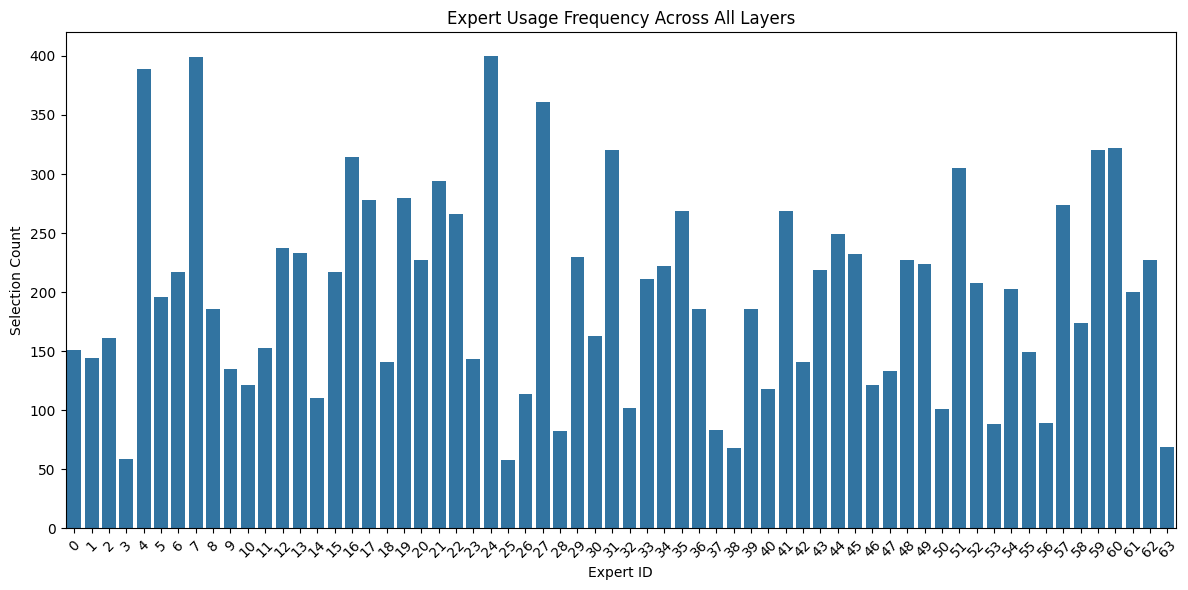

In [ ]:
# Overall expert usage frequency (bar plot)
expert_freq = expert_freq_per_layer.sum(axis=0)
plt.figure(figsize=(12, 6))
sns.barplot(x=range(num_experts), y=expert_freq)
plt.title("Expert Usage Frequency Across All Layers")
plt.xlabel("Expert ID")
plt.ylabel("Selection Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This visualization reveals that Experts 4, 7, and 24 demonstrate significantly higher activation counts compared to other experts during Korean flashcard generation. This pattern suggests these experts have developed specialized capabilities for Korean language tasks, likely through exposure to Korean grammatical structures, vocabulary patterns, or cross-lingual translation mechanisms during training. The layered activation (across all 16 layers) implies these experts handle both foundational linguistic features (early layers) and higher-level semantic relationships (later layers) specific to Korean.

#### Expert Logits Heatmap:

The heatmap shows the gate logits for each of the 64 experts in Layer 0 across input token positions for the flashcard generation prompt. Brighter colors represent higher logit values, indicating a greater likelihood of an expert being selected for a given token. This visualization reveals how the MoE model routes tokens to experts at the start of the transformer stack.

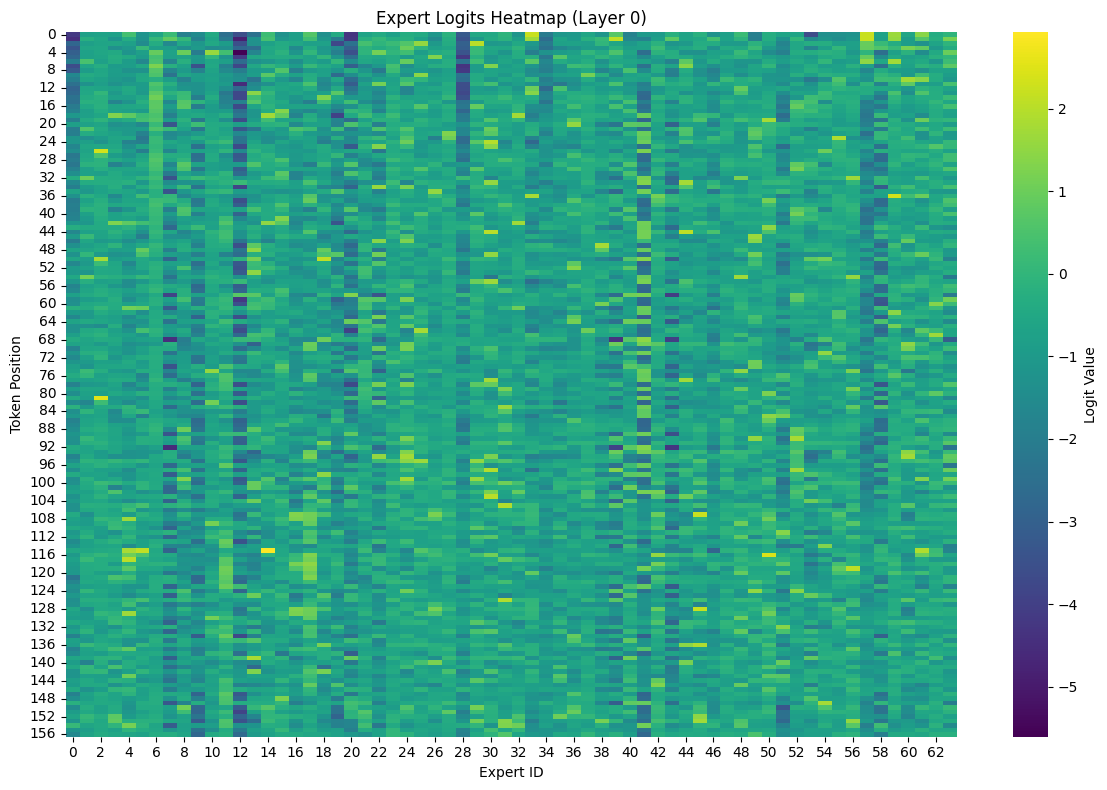

In [ ]:
# Heatmap of expert weights for the first layer
first_layer_logits = expert_activations[0].squeeze(0)
plt.figure(figsize=(12, 8))
sns.heatmap(first_layer_logits.numpy(), cmap="viridis", cbar_kws={'label': 'Logit Value'})
plt.title("Expert Logits Heatmap (Layer 0)")
plt.xlabel("Expert ID")
plt.ylabel("Token Position")
plt.tight_layout()
plt.show()

The heatmap visualizes expert selection dynamics in Layer 0 of OLMoE during Korean flashcard generation, where each column represents an expert (1-64) and each row corresponds to an input token position. Brighter yellow cells indicate higher gate logits (pre-softmax scores), signaling stronger expert candidacy for specific tokens. For instance, at Token 0 (likely the task-initiating token), Experts 33, 57, 59, and 61 show high activation potential, suggesting they specialize in foundational Korean language processing-such as task framing, Hangul character recognition, or cross-lingual alignment-while darker blue areas reflect experts less relevant to early processing stages. This pattern highlights how MoE models dynamically route tokens to specialized sub-networks, with early layers establishing task-specific computational pathways that influence downstream expert activation.

#### Expert Selection Frequency by Layer Stacked Bar Plot:

This stacked bar plot illustrates the frequency of expert selections (top-2 per token) for each of the 16 transformer layers in the OLMoE model. Each bar segment represents an expert’s contribution, with colors distinguishing different experts. It highlights how expert usage varies across layers, showing the MoE’s layer-wise routing behavior.

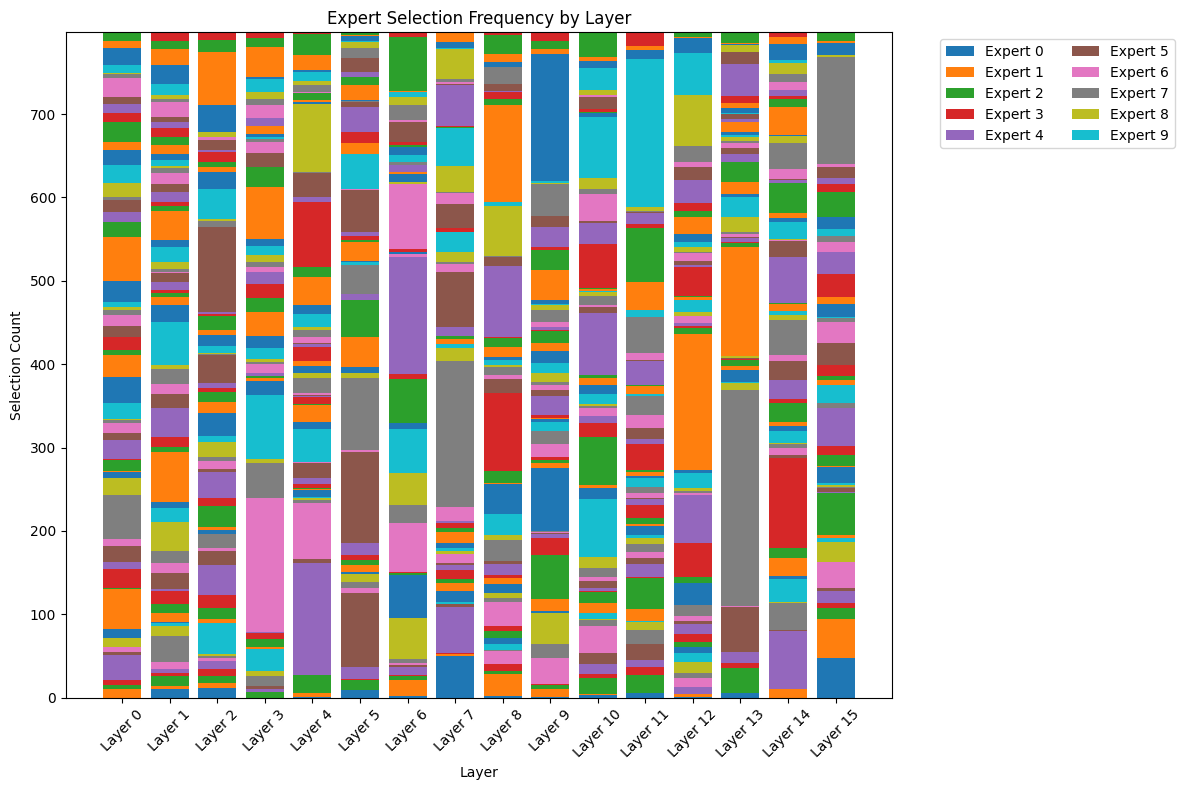

In [ ]:
# Stacked bar plot of expert selections per layer
plt.figure(figsize=(12, 8))
bottom = np.zeros(num_layers)
for expert_id in range(num_experts):
    plt.bar(range(num_layers), expert_freq_per_layer[:, expert_id], bottom=bottom, label=f"Expert {expert_id}" if expert_id < 10 else None)
    bottom += expert_freq_per_layer[:, expert_id]
plt.title("Expert Selection Frequency by Layer")
plt.xlabel("Layer")
plt.ylabel("Selection Count")
plt.xticks(range(num_layers), [f"Layer {i}" for i in range(num_layers)], rotation=45)  # Rotate x-labels
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

Unlike the first bar chart which aggregated counts by expert, this plot organizes the data by layer, showing the distribution of expert activations within each layer. For clarity, only the top 10 most frequently selected experts per layer are displayed. A notable pattern emerges in the deeper layers, where expert activations become increasingly centralized-fewer experts dominate the routing decisions-suggesting that as the model processes information through its layers, it relies more heavily on a specialized subset of experts. This behavior reflects the MoE architecture’s dynamic routing mechanism, where early layers may distribute processing more broadly, while deeper layers focus computation on experts most specialized for the task at hand.

This final animation builds on our previous visualizations of the Mixture-of-Experts (MoE) architecture, but with a thematic focus tailored to the Korean flashcard generation task we just explored.

In [50]:
%%manim -qm -v WARNING OlmoeArchitectureAnimation

Manim Community v0.19.0

# References

[1] Jacobs, R. A., Jordan, M. I., Nowlan, S. J., & Hinton, G. E. (1991). Adaptive mixtures of local experts. Neural Computation, 3(1), 79–87.

[2] Shazeer, N., Mirhoseini, A., Maziarz, K., Davis, A., Lee, Q., Hinton, G., & Dean, J. (2017). Outrageously large neural networks: The sparsely-gated mixture-of-experts layer. arXiv preprint arXiv:1701.06538.

[3] Jiang, S., Zheng, T., Zhang, Y., Jin, Y., Yuan, L., & Liu, Z. (2024). Med-MoE: Mixture of domain-specific experts for lightweight medical vision-language models. arXiv preprint.

[4] Vaswani, A., et al. (2017). Attention is All You Need. arXiv:1706.03762.

[5] Niklas Muennighoff, Luca Soldaini, Dirk Groeneveld, Kyle Lo, Jacob Morrison, Sewon Min, Weijia Shi, Pete
Walsh, Oyvind Tafjord, Nathan Lambert, Yuling Gu, Shane Arora, Akshita Bhagia, Dustin Schwenk, David
Wadden, Alexander Wettig, Binyuan Hui, Tim Dettmers, Douwe Kiela, Ali Farhadi, Noah A. Smith, Pang Wei
Koh, Amanpreet Singh, and Hannaneh Hajishirzi. Olmoe: Open mixture-of-experts language models, 2025.


[6] The Manim Community Developers. (2025). Manim – Mathematical Animation Framework (Version v0.19.0) [Computer software]. https://www.manim.community/